# CICY4: A single NN for h11, h21, h31, h22

In [1]:
import numpy as np
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("darkgrid")

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# load data
path = '/kaggle/input/calabi-yau-cicy-4-folds'
conf = np.load(os.path.join(path, 'conf.npy'))
hodge = np.load(os.path.join(path, 'hodge.npy'))
direct = np.load(os.path.join(path, 'direct.npy'))
conf.shape, hodge.shape, direct.shape

((921497, 16, 20), (921497, 4), (921497,))

In [3]:
X = conf
h11 = hodge[:,0]
h21 = hodge[:,1]
h22 = hodge[:,3]
h31 = hodge[:,2]
h11max = np.max(hodge[:,0])
h11min = np.min(hodge[:,0])
print(f'Max h11: {h11max}, Min h11: {h11min} ')
h21max = np.max(hodge[:,1])
h21min = np.min(hodge[:,1])
print(f'Max h21: {h21max}, Min h21: {h21min} ')
h31max = np.max(hodge[:,2])
h31min = np.min(hodge[:,2])
print(f'Max h31: {h31max}, Min h31: {h31min} ')
h22max = np.max(hodge[:,3])
h22min = np.min(hodge[:,3])
print(f'Max h22: {h22max}, Min h22: {h22min} ')

Max h11: 24, Min h11: 0 
Max h21: 33, Min h21: 0 
Max h31: 426, Min h31: 0 
Max h22: 1752, Min h22: 0 


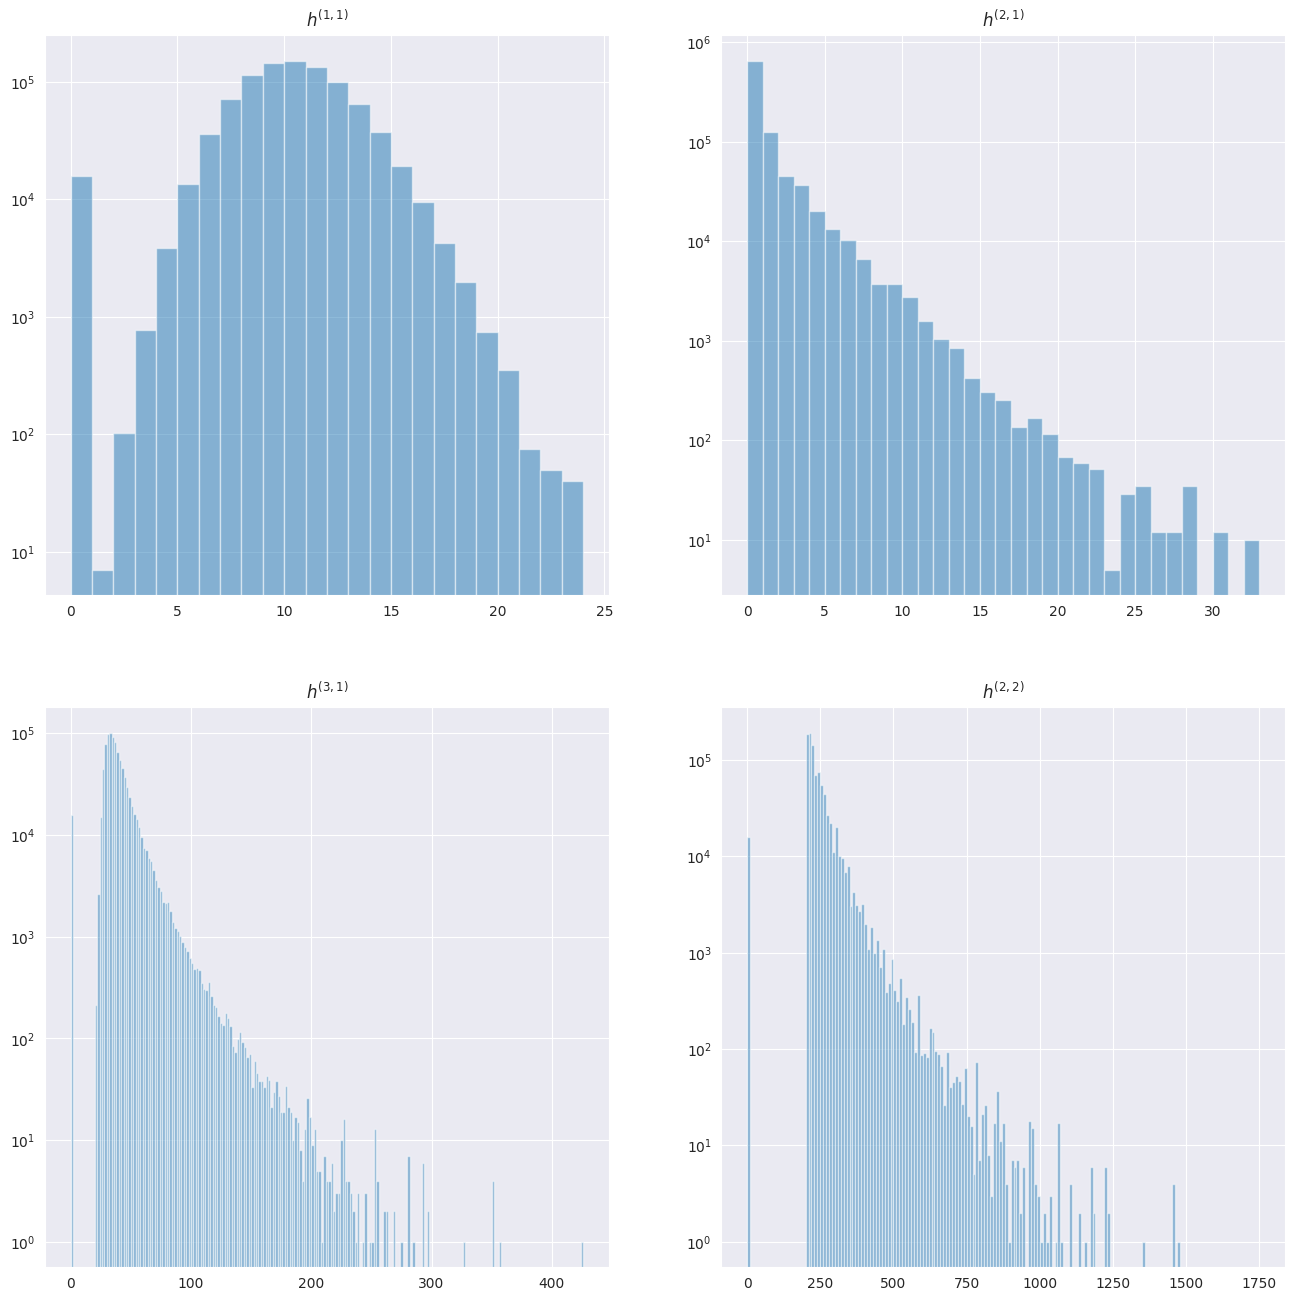

In [40]:
fig, ax = plt.subplots(2,2, figsize = (16,16))
ax[0,0].hist(hodge[:,0], bins=range(h11min, h11max+1), alpha=0.5)
ax[0,0].set_title('$h^{(1,1)}$')
#ax[0,0].ylabel('count')
ax[0,0].set_yscale('log')

ax[0,1].hist(hodge[:,1], bins=range(h21min, h21max+1), alpha=0.5)
ax[0,1].set_title('$h^{(2,1)}$')
#ax[0,0].ylabel('count')
ax[0,1].set_yscale('log')

ax[1,0].hist(hodge[:,2], bins=range(h31min, h31max+1, 2), alpha=0.5)
ax[1,0].set_title('$h^{(3,1)}$')
#ax[0,0].ylabel('count')
ax[1,0].set_yscale('log')

ax[1,1].hist(hodge[:,3], bins=range(h22min, h22max+1,10), alpha=0.5)
ax[1,1].set_title('$h^{(2,2)}$')
#ax[0,0].ylabel('count')
ax[1,1].set_yscale('log')

# Import predefined functions and prepare data

In [4]:
import sys
sys.path.append('/kaggle/input/calabi-yau-cicy-4-folds')
from CICY4_functions import data_generator, batch_gd,  calc_accuracy

In [5]:
from sklearn.model_selection import train_test_split

def train_test(X, y):
    X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, shuffle = True)
    
    X_train = torch.from_numpy(X_train.astype(np.float32))
    #only need reshape if the y dimension is 1
    #y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1, 1))
    y_train = torch.from_numpy(y_train.astype(np.float32))

    X_test = torch.from_numpy(X_test.astype(np.float32))
    #y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1, 1))
    y_test = torch.from_numpy(y_test.astype(np.float32))                         
    
    print(f'X_train shape: {X_train.shape}, \n y_train shape:{y_train.shape},\
                 \n X_test shape: {X_test.shape}, \n y_test shape:{y_test.shape}')
    return X_train, X_test, y_train, y_test

In [6]:
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
y = np.zeros((921497,4))
y[:,0] = h11
y[:,1] = h21
y[:,2] = h31
y[:,3] = h22

In [9]:
y.shape, np.array_equal(y[:,0],h11)

((921497, 4), True)

In [10]:
X_train, X_test, y_train, y_test = train_test(X, y)

X_train shape: torch.Size([737197, 16, 20]), 
 y_train shape:torch.Size([737197, 4]),                 
 X_test shape: torch.Size([184300, 16, 20]), 
 y_test shape:torch.Size([184300, 4])


In [11]:
train_gen = lambda: data_generator(X_train, y_train)
test_gen = lambda: data_generator(X_test, y_test)

In [12]:
def plot_losses(train_losses, test_losses):
    # Plot the train loss and test loss per iteration
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.legend()
    plt.show()

In [ ]:
################## ACCURACY CALCULATION #####################
def calc_accuracy_mr(model, train_gen, test_gen, device, cnn = False):
    model.eval()
    n_correct_h11 = 0.
    n_total_h11 = 0.
    n_correct_h21 = 0.
    n_total_h21 = 0.
    n_correct_h31 = 0.
    n_total_h31 = 0.
    n_correct_h22 = 0.
    n_total_h22 = 0.
    
    batch_size =128
    
    for inputs, target in train_gen():
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        #Perform the prediction
        #round up the prediction to the nearest integer
        ypred = torch.round(model(inputs))
        yp_h11 = ypred[:,0]
        yp_h21 = ypred[:,1]
        yp_h31 = ypred[:,2]
        yp_h22 = ypred[:,3]
        tg_h11 = target[:,0]
        tg_h21 = target[:,1]
        tg_h31 = target[:,2]
        tg_h22 = target[:,3]
        # update counts
        n_correct_h11 += (yp_h11 == tg_h11).sum().item()
        n_total_h11 += tg_h11.shape[0]
        n_correct_h21 += (yp_h21 == tg_h21).sum().item()
        n_total_h21 += tg_h21.shape[0]
        n_correct_h31 += (yp_h31 == tg_h31).sum().item()
        n_total_h31 += tg_h31.shape[0]
        n_correct_h22 += (yp_h22 == tg_h22).sum().item()
        n_total_h22 += tg_h22.shape[0]
    train_acc_h11 = n_correct_h11 / n_total_h11
    train_acc_h21 = n_correct_h21 / n_total_h21
    train_acc_h31 = n_correct_h31 / n_total_h31
    train_acc_h22 = n_correct_h22 / n_total_h22
    
    #TEST SET
    n_correct_h11 = 0.
    n_total_h11 = 0.
    n_correct_h21 = 0.
    n_total_h21 = 0.
    n_correct_h31 = 0.
    n_total_h31 = 0.
    n_correct_h22 = 0.
    n_total_h22 = 0.
    for inputs, target in test_gen():
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        
        # Forward pass
        ypred = torch.round(model(inputs))
        yp_h11 = ypred[:,0]
        yp_h21 = ypred[:,1]
        yp_h31 = ypred[:,2]
        yp_h22 = ypred[:,3]
        tg_h11 = target[:,0]
        tg_h21 = target[:,1]
        tg_h31 = target[:,2]
        tg_h22 = target[:,3]
        # update counts
        n_correct_h11 += (yp_h11 == tg_h11).sum().item()
        n_total_h11 += tg_h11.shape[0]
        n_correct_h21 += (yp_h21 == tg_h21).sum().item()
        n_total_h21 += tg_h21.shape[0]
        n_correct_h31 += (yp_h31 == tg_h31).sum().item()
        n_total_h31 += tg_h31.shape[0]
        n_correct_h22 += (yp_h22 == tg_h22).sum().item()
        n_total_h22 += tg_h22.shape[0]
    test_acc_h11 = n_correct_h11 / n_total_h11
    test_acc_h21 = n_correct_h21 / n_total_h21
    test_acc_h31 = n_correct_h31 / n_total_h31
    test_acc_h22 = n_correct_h22 / n_total_h22
    
    train_acc = [train_acc_h11,train_acc_h21,train_acc_h31,train_acc_h22]
    test_acc = [test_acc_h11,test_acc_h21,test_acc_h31,test_acc_h22]

    return train_acc, test_acc

# CNN model

In [13]:
##################### CNN ###############################
class CNN_cicy4(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,128, 4, 1)
        self.conv2 = nn.Conv2d(128,64, 3, 1)
        self.mxpool = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        self.conv_total = nn.Sequential(
            self.conv1,
            self.mxpool,
            self.conv2,
            self.mxpool,
        )
        self.linear1 = nn.Linear(384,1024)
        self.linear2 = nn.Linear(1024,512)
        self.linear3 = nn.Linear(512,128)
        self.linear4 = nn.Linear(128,4)


    def forward(self,x):
        x = F.relu(self.conv_total(x))
        x = self.flat(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        
        return x

In [14]:
model = CNN_cicy4()
model.to(device)

CNN_cicy4(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (conv_total): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Linear(in_features=384, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=4, bias=True)
)

In [15]:
#count the number of parameters in the model
params = [p.numel() for p in model.parameters() if p.requires_grad]
for item in params:
    print(f'{item:>8}')
print(f'________\n{sum(params):>8}')

    2048
     128
   73728
      64
  393216
    1024
  524288
     512
   65536
     128
     512
       4
________
 1061188


In [27]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

## Shape Tracing

In [17]:
X = X_train[0].to(device)
print(f'Original shape of the image before passing through the network: \n {X.shape}\n')

print('Reshape the size to take in account the batch number')
X = X.view(1,1,16,20)
print(f'The new size is {X.shape}\n')

X = model.conv_total(X)
print(f'Original shape of the image after passing through {model.conv_total}: \n {X.shape}\n')

X = model.flat(X)
print(f'Original shape of the image after passing through {model.flat}: \n {X.shape}\n')

X = model.linear1(X)
print(f'Shape of the image after passing through the {model.linear1}: \n {X.shape}\n')

X = model.linear2(X)
print(f'Shape of the image after passing through the {model.linear2}: \n {X.shape}\n')

X = model.linear3(X)
print(f'Shape of the image after passing through the {model.linear3}: \n {X.shape}\n')

X = model.linear4(X)
print(f'Shape of the image after passing through the {model.linear4}: \n {X.shape}\n')
 
print(X)

Original shape of the image before passing through the network: 
 torch.Size([16, 20])

Reshape the size to take in account the batch number
The new size is torch.Size([1, 1, 16, 20])

Original shape of the image after passing through Sequential(
  (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
): 
 torch.Size([1, 64, 2, 3])

Original shape of the image after passing through Flatten(start_dim=1, end_dim=-1): 
 torch.Size([1, 384])

Shape of the image after passing through the Linear(in_features=384, out_features=1024, bias=True): 
 torch.Size([1, 1024])

Shape of the image after passing through the Linear(in_features=1024, out_features=512, bias=True): 
 torch.Size([1, 512])

Shape of the image after passing through the Linear(in_features=512, out_features=128

In [35]:
#PRINT OUT SOME OUTPUTS TO COMPARE BETWEEN PREDICTIONS AND TARGETS
for inputs, target in train_gen():
    inputs = inputs.view(-1,1,16,20)
    inputs, target = inputs.to(device), target.to(device)
    #Perform the prediction
    #ypred = torch.round(model(inputs))
    ypred = (model(inputs))
    print(f'Target shape: {target.shape}, \n Target[1]: {target[:1]}\n')
    print(f'Prediction shape: {ypred.shape},\n Prediction[1]:{ypred[:1]}\n')

    MAE = nn.L1Loss()
    MSE = nn.MSELoss()
    loss = MAE(ypred[:1], target[:1])
    print(f'MAE Loss: {loss}')
    loss2 = MSE(ypred[:1], target[:1])
    print(f'MSE Loss: {loss2}')
    break

Target shape: torch.Size([128, 4]), 
 Target[1]: tensor([[ 14.,   9.,  35., 222.]], device='cuda:0')

Prediction shape: torch.Size([128, 4]),
 Prediction[1]:tensor([[ 0.0141,  0.0709, -0.0507,  0.0699]], device='cuda:0',
       grad_fn=<SliceBackward0>)

MAE Loss: 69.97396087646484
MSE Loss: 12689.2119140625


# Train loop

In [36]:
train_losses, test_losses=batch_gd(model, criterion, optimizer, train_gen, test_gen, 100, device, 128, cnn=True)

Epoch: 1/100, train loss:  683.8627          test_loss:  400.8497, duration: 0:00:18.181760
Epoch: 2/100, train loss:  246.1006          test_loss:  176.2475, duration: 0:00:18.054813
Epoch: 3/100, train loss:  151.4382          test_loss:  132.0266, duration: 0:00:18.087635
Epoch: 4/100, train loss:  120.3194          test_loss:  113.4319, duration: 0:00:17.952235
Epoch: 5/100, train loss:  102.4962          test_loss:  112.0876, duration: 0:00:18.012518
Epoch: 6/100, train loss:  90.8473          test_loss:  95.2856, duration: 0:00:17.901642
Epoch: 7/100, train loss:  82.5872          test_loss:  80.8510, duration: 0:00:18.044242
Epoch: 8/100, train loss:  76.9582          test_loss:  84.2093, duration: 0:00:17.914016
Epoch: 9/100, train loss:  72.1315          test_loss:  75.6078, duration: 0:00:18.000775
Epoch: 10/100, train loss:  68.1869          test_loss:  72.2946, duration: 0:00:17.982010
Epoch: 11/100, train loss:  65.4161          test_loss:  88.4472, duration: 0:00:17.93664

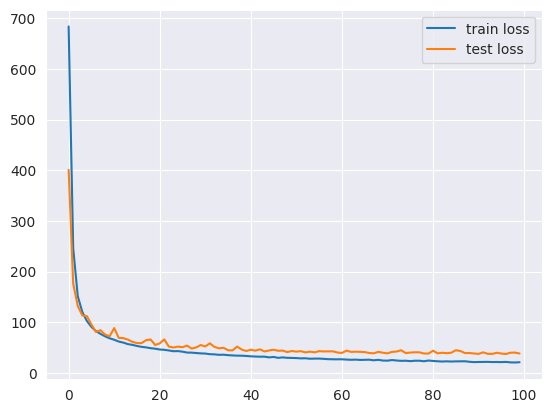

In [37]:
plot_losses(train_losses, test_losses)

##  Calculate accuracy

In [66]:
#PRINT OUT SOME OUTPUTS TO COMPARE BETWEEN PREDICTIONS AND TARGETS
for inputs, target in test_gen():
    inputs = inputs.view(-1,1,16,20)
    inputs, target = inputs.to(device), target.to(device)
    #Perform the prediction
    #ypred = torch.round(model(inputs))
    ypred = torch.round(model(inputs))
    print(f'Target shape: {target.shape}, \n Target[1]: {target[:1]}\n')
    print(f'Prediction shape: {ypred.shape},\n Prediction[1]:{ypred[:1]}\n')
    loss = criterion(ypred[:1], target[:1])
    print(f'Loss: {loss}')
    print(ypred[:1]== target[:1])
    break

Target shape: torch.Size([128, 4]), 
 Target[1]: tensor([[ 16.,   0.,  24., 204.]], device='cuda:0')

Prediction shape: torch.Size([128, 4]),
 Prediction[1]:tensor([[ 14.,   0.,  26., 205.]], device='cuda:0', grad_fn=<SliceBackward0>)

Loss: 2.25
tensor([[False,  True, False, False]], device='cuda:0')


In [63]:
train_acc, test_acc = calc_accuracy_mr(model, train_gen , test_gen, device = device, cnn= True)


In [64]:
print(f'Train accuracy for h11:{train_acc[0]:.4f}, Test accuracy for h11: {test_acc[0]:.4f}')
print(f'Train accuracy for h21:{train_acc[1]:.4f}, Test accuracy for h21: {test_acc[1]:.4f}')
print(f'Train accuracy for h31:{train_acc[2]:.4f}, Test accuracy for h31: {test_acc[2]:.4f}')
print(f'Train accuracy for h22:{train_acc[3]:.4f}, Test accuracy for h22: {test_acc[3]:.4f}')

Train accuracy for h11:0.3442, Test accuracy for h11: 0.3453
Train accuracy for h21:0.5791, Test accuracy for h21: 0.5729
Train accuracy for h31:0.2058, Test accuracy for h31: 0.1876
Train accuracy for h22:0.0729, Test accuracy for h22: 0.0659


In [65]:
torch.save(model, '/kaggle/working/saved_models/CNN_cicy4_Hodge.pt')

# RNN model

In [67]:
class RNN_cicy4(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN_cicy4,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.rnn = nn.LSTM(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)
        self.fc = nn.Linear(self.M, self.K)
       
    def forward(self, X):
         #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        #get LSTM unit output:
        #size NxTxM
        out, _ = self.rnn(X, (h0,c0))

        #we only want h(T) at the final time step
        out = self.fc(out[:, -1, :])

        return out

In [69]:
#( n_inputs, n_hidden, n_rnnlayers, n_outputs)
# n_inputs = D = # of columns: 20, T = 16
#input shape is NxTxD: Nx16x20
model = RNN_cicy4(20, 80, 5, 4 )
model.to(device)

RNN_cicy4(
  (rnn): LSTM(20, 80, num_layers=5, batch_first=True)
  (fc): Linear(in_features=80, out_features=4, bias=True)
)

In [70]:
#count the number of parameters in the model
params = [p.numel() for p in model.parameters() if p.requires_grad]
for item in params:
    print(f'{item:>8}')
print(f'________\n{sum(params):>8}')

    6400
   25600
     320
     320
   25600
   25600
     320
     320
   25600
   25600
     320
     320
   25600
   25600
     320
     320
   25600
   25600
     320
     320
     320
       4
________
  240324


In [71]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
train_losses, test_losses=batch_gd(model, criterion, optimizer, train_gen, test_gen, 60, device, 128, cnn=False)

Epoch: 1/60, train loss:  3530.7030          test_loss:  904.2463, duration: 0:00:22.187501
Epoch: 2/60, train loss:  904.9615          test_loss:  904.1041, duration: 0:00:21.984485
Epoch: 3/60, train loss:  904.9741          test_loss:  904.3856, duration: 0:00:22.217565
Epoch: 4/60, train loss:  904.9710          test_loss:  904.1427, duration: 0:00:22.111608
Epoch: 5/60, train loss:  904.8273          test_loss:  904.3721, duration: 0:00:22.191793
Epoch: 6/60, train loss:  905.0237          test_loss:  903.9374, duration: 0:00:22.103116
Epoch: 7/60, train loss:  905.0042          test_loss:  904.4280, duration: 0:00:22.135351
Epoch: 8/60, train loss:  904.9791          test_loss:  904.4432, duration: 0:00:22.182258
Epoch: 9/60, train loss:  904.9305          test_loss:  904.2277, duration: 0:00:22.078712
Epoch: 10/60, train loss:  905.0141          test_loss:  904.0916, duration: 0:00:22.073165
Epoch: 11/60, train loss:  904.9369          test_loss:  904.0406, duration: 0:00:22.234

In [ ]:
plot_losses(train_losses, test_losses)

In [ ]:
train_acc, test_acc = calc_accuracy_mr(model, train_gen , test_gen, device = device, cnn= False)
print(f'Train accuracy for h11:{train_acc[0]:.4f}, Test accuracy for h11: {test_acc[0]:.4f}')
print(f'Train accuracy for h21:{train_acc[1]:.4f}, Test accuracy for h21: {test_acc[1]:.4f}')
print(f'Train accuracy for h31:{train_acc[2]:.4f}, Test accuracy for h31: {test_acc[2]:.4f}')
print(f'Train accuracy for h22:{train_acc[3]:.4f}, Test accuracy for h22: {test_acc[3]:.4f}')